# Part 1: Network Construction

In [ ]:
import zipfile
import os

# Define the path to the zip file
zip_file_path = 'Heart.zip'
output_dir = 'Heart_dataset/'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

# List the contents of the extracted directory
extracted_files = os.listdir(output_dir)
extracted_files


['Heart', '__MACOSX']

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.nn import BCELoss
import matplotlib.pyplot as plt

# Define the U-Net model
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, init_features=16):
        super(UNet, self).__init__()
        features = init_features

        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(in_channels=features, out_channels=out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=features,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
        )

In [ ]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class HeartDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.JPG') or f.endswith('.jpg')])
        self.mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.PNG') or f.endswith('.png')])

        # Create a dictionary to map image identifiers to mask files
        self.image_to_mask = self._match_images_and_masks(self.image_files, self.mask_files)

    def _match_images_and_masks(self, image_files, mask_files):
        image_to_mask = {}
        for image_file in image_files:
            image_id = self._extract_identifier(image_file)
            for mask_file in mask_files:
                mask_id = self._extract_identifier(mask_file)
                if image_id == mask_id:
                    image_to_mask[image_file] = mask_file
                    break
        return image_to_mask

    def _extract_identifier(self, filename):
        # Extract identifier after the first underscore and before the file extension
        return "_".join(filename.split('_')[1:]).split('.')[0]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        mask_file = self.image_to_mask.get(image_file, None)

        if mask_file is None:
            raise ValueError(f"No corresponding mask found for image {image_file}")

        image_path = os.path.join(self.image_dir, image_file)
        mask_path = os.path.join(self.mask_dir, mask_file)

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        # Convert mask to binary (0 or 1)
        mask = np.array(mask)
        mask = (mask > 0).astype(np.float32)
        mask = Image.fromarray(mask)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Define image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Paths to the images and masks directories
train_image_dir = 'Heart_dataset/Heart/images/tr'
train_mask_dir = 'Heart_dataset/Heart/golds'
val_image_dir = 'Heart_dataset/Heart/images/val'
val_mask_dir = 'Heart_dataset/Heart/golds'
test_image_dir = 'Heart_dataset/Heart/images/ts'
test_mask_dir = 'Heart_dataset/Heart/golds'

# Create dataset objects
train_dataset = HeartDataset(train_image_dir, train_mask_dir, transform=transform)
val_dataset = HeartDataset(val_image_dir, val_mask_dir, transform=transform)
test_dataset = HeartDataset(test_image_dir, test_mask_dir, transform=transform)

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Image: CT_1_Image_43.jpg, Mask: gold_1_Image_43.png
Image: CT_1_Image_44.jpg, Mask: gold_1_Image_44.png
Image: CT_1_Image_45.jpg, Mask: gold_1_Image_45.png
Image: CT_1_Image_46.jpg, Mask: gold_1_Image_46.png
Image: CT_1_Image_47.jpg, Mask: gold_1_Image_47.png


Image: CT_10_Image_38.jpg, Mask: gold_10_Image_38.png
Image: CT_10_Image_39.jpg, Mask: gold_10_Image_39.png
Image: CT_10_Image_40.jpg, Mask: gold_10_Image_40.png
Image: CT_10_Image_41.jpg, Mask: gold_10_Image_41.png
Image: CT_10_Image_42.jpg, Mask: gold_10_Image_42.png


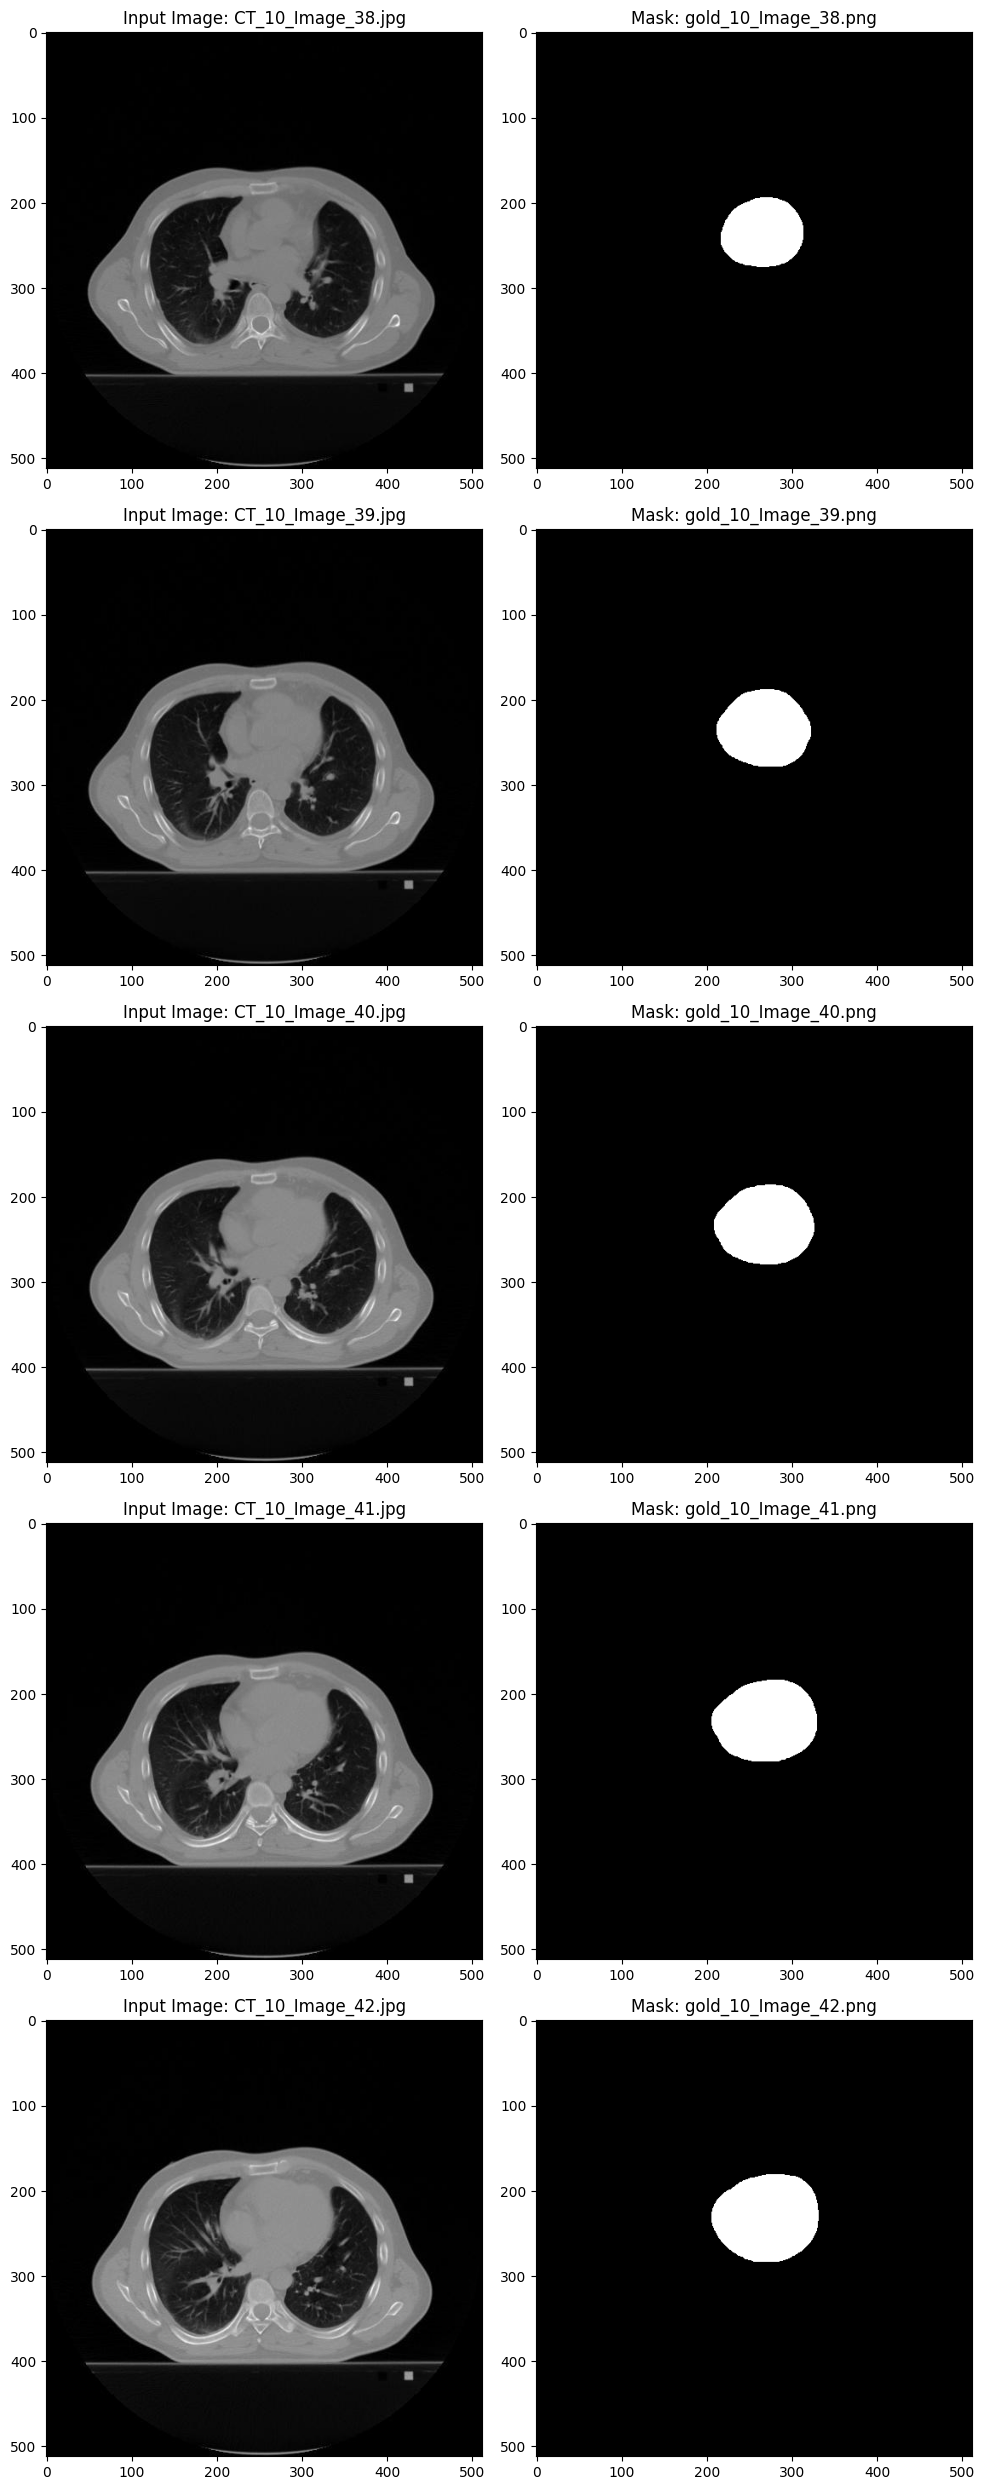

Image: CT_11_Image_47.jpg, Mask: gold_11_Image_47.png
Image: CT_11_Image_48.jpg, Mask: gold_11_Image_48.png
Image: CT_11_Image_49.jpg, Mask: gold_11_Image_49.png
Image: CT_11_Image_50.jpg, Mask: gold_11_Image_50.png
Image: CT_11_Image_51.jpg, Mask: gold_11_Image_51.png


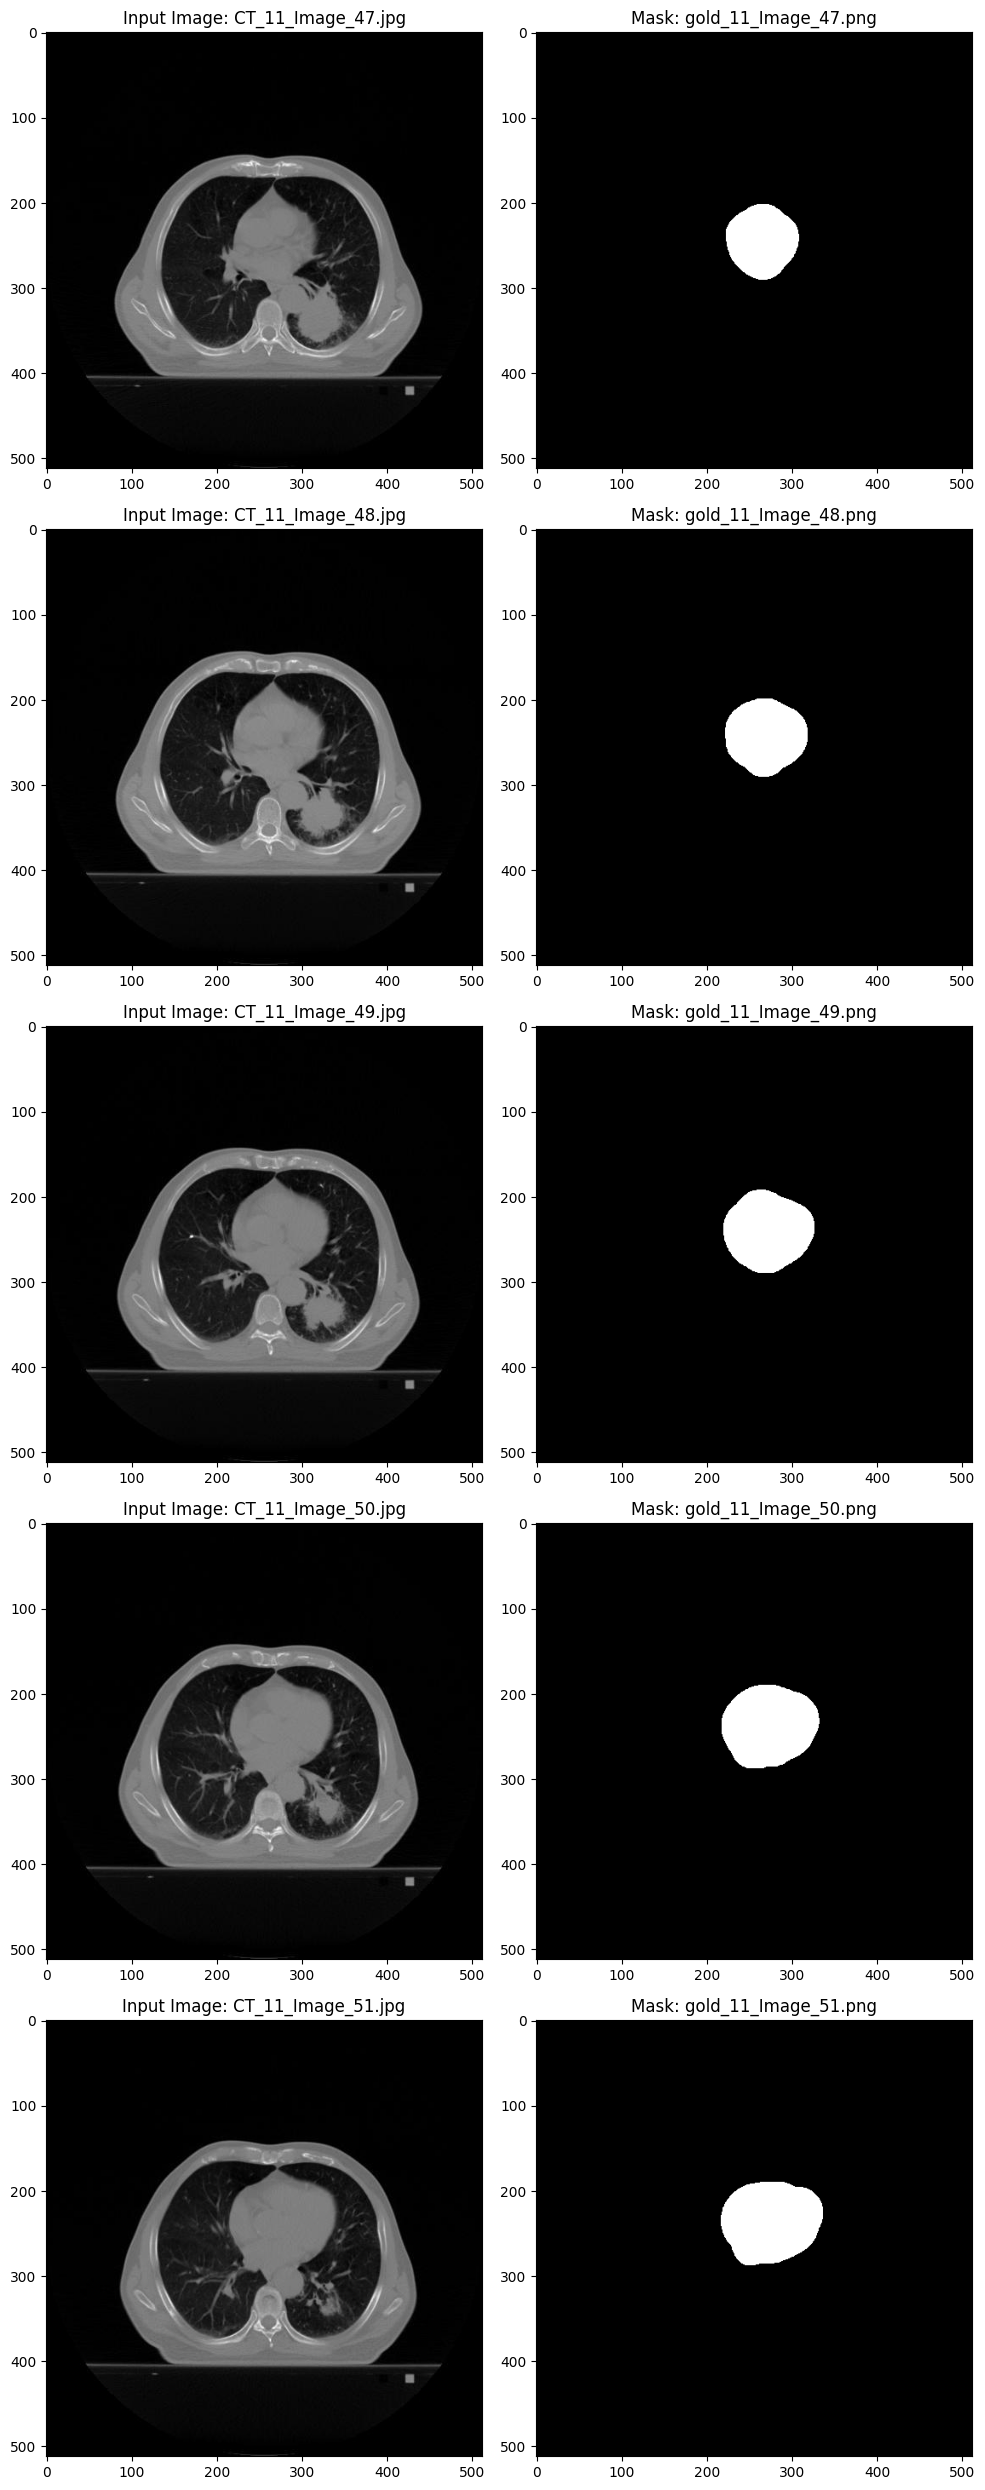

In [ ]:
def visualize_data_loader(data_loader, dataset, num_samples=5):
    data_iter = iter(data_loader)
    images, masks = next(data_iter)

    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))

    for i in range(num_samples):
        image = images[i].numpy().squeeze()
        mask = masks[i].numpy().squeeze()

        image_file = dataset.image_files[i]
        mask_file = dataset.image_to_mask[image_file]

        axes[i, 0].imshow(image, cmap='gray')
        axes[i, 0].set_title(f'Input Image: {image_file}')

        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title(f'Mask: {mask_file}')

        print(f"Image: {image_file}, Mask: {mask_file}")

    plt.tight_layout()
    plt.show()

# Visualize a batch of training data
visualize_data_loader(train_loader, train_dataset, num_samples=5)

# Visualize a batch of validation data
visualize_data_loader(val_loader, val_dataset, num_samples=5)

# Visualize a batch of test data
visualize_data_loader(test_loader, test_dataset, num_samples=5)


In [41]:
# Helper functions
def calculate_metrics(pred, target):
    pred = pred > 0.5
    target = target > 0.5
    tp = (pred & target).sum().float()
    tn = ((~pred) & (~target)).sum().float()
    fp = (pred & (~target)).sum().float()
    fn = ((~pred) & target).sum().float()

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    return precision.item(), recall.item(), f1.item()

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    best_f1 = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

        val_loss, val_precision, val_recall, val_f1 = validate_model(model, val_loader, criterion)
        print(f"Validation Loss: {val_loss:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")

        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pth')

def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    val_precision, val_recall, val_f1 = 0.0, 0.0, 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item() * images.size(0)
            precision, recall, f1 = calculate_metrics(outputs, masks)
            val_precision += precision
            val_recall += recall
            val_f1 += f1

    val_loss /= len(val_loader.dataset)
    val_precision /= len(val_loader)
    val_recall /= len(val_loader)
    val_f1 /= len(val_loader)

    return val_loss, val_precision, val_recall, val_f1

def test_model(model, test_loader):
    model.eval()
    test_precision, test_recall, test_f1 = 0.0, 0.0, 0.0
    test_images = []
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            precision, recall, f1 = calculate_metrics(outputs, masks)
            test_precision += precision
            test_recall += recall
            test_f1 += f1

            if len(test_images) < 6:
                test_images.append((images.cpu(), masks.cpu(), outputs.cpu()))

        test_precision /= len(test_loader)
        test_recall /= len(test_loader)
        test_f1 /= len(test_loader)

    print(f"Test Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")

    visualize_results(test_images)



In [ ]:
def Training_results(model, train_loader):
    model.eval()
    train_precision, train_recall, train_f1 = 0.0, 0.0, 0.0
    train_images = []
    with torch.no_grad():
        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            precision, recall, f1 = calculate_metrics(outputs, masks)
            train_precision += precision
            train_recall += recall
            train_f1 += f1

            if len(train_images) < 6:
                train_images.append((images.cpu(), masks.cpu(), outputs.cpu()))

        train_precision /= len(train_loader)
        train_recall /= len(train_loader)
        train_f1 /= len(train_loader)

    print(f"Train Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}")


In [ ]:

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate and train the model
model = UNet(in_channels=1, out_channels=1, init_features=16).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = BCELoss()

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25)


Epoch 1/25, Loss: 0.7615
Validation Loss: 0.6965, Precision: 0.0280, Recall: 1.0000, F1 Score: 0.0544
Epoch 2/25, Loss: 0.7167
Validation Loss: 0.6993, Precision: 0.0435, Recall: 1.0000, F1 Score: 0.0834
Epoch 3/25, Loss: 0.6823
Validation Loss: 0.6885, Precision: 0.1011, Recall: 0.9999, F1 Score: 0.1834
Epoch 4/25, Loss: 0.6549
Validation Loss: 0.6599, Precision: 0.1086, Recall: 0.9906, F1 Score: 0.1954
Epoch 5/25, Loss: 0.6329
Validation Loss: 0.6349, Precision: 0.1102, Recall: 0.9675, F1 Score: 0.1975
Epoch 6/25, Loss: 0.6168
Validation Loss: 0.6176, Precision: 0.1020, Recall: 0.7817, F1 Score: 0.1802
Epoch 7/25, Loss: 0.6025
Validation Loss: 0.6400, Precision: 0.1030, Recall: 0.7750, F1 Score: 0.1816
Epoch 8/25, Loss: 0.5896
Validation Loss: 0.6120, Precision: 0.1209, Recall: 0.9827, F1 Score: 0.2149
Epoch 9/25, Loss: 0.5784
Validation Loss: 0.5932, Precision: 0.1322, Recall: 0.9866, F1 Score: 0.2327
Epoch 10/25, Loss: 0.5663
Validation Loss: 0.5705, Precision: 0.2160, Recall: 0.95

In [ ]:
def visualize_results(test_images):
    num_samples = len(test_images)
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))

    for i, (images, masks, outputs) in enumerate(test_images):
        # Display only the first image in each batch
        image = images[0].numpy().squeeze()
        mask = masks[0].numpy().squeeze()
        output = outputs[0].numpy().squeeze() > 0.5

        axes[i, 0].imshow(image, cmap='gray')
        axes[i, 0].set_title('Input')

        axes[i, 1].imshow(output, cmap='gray')
        axes[i, 1].set_title('Prediction')

    plt.tight_layout()
    plt.show()


In [ ]:
Training_results(model, train_loader)

Train Precision: 0.8892, Recall: 0.9487, F1 Score: 0.9179


Test Precision: 0.8100, Recall: 0.8897, F1 Score: 0.8456


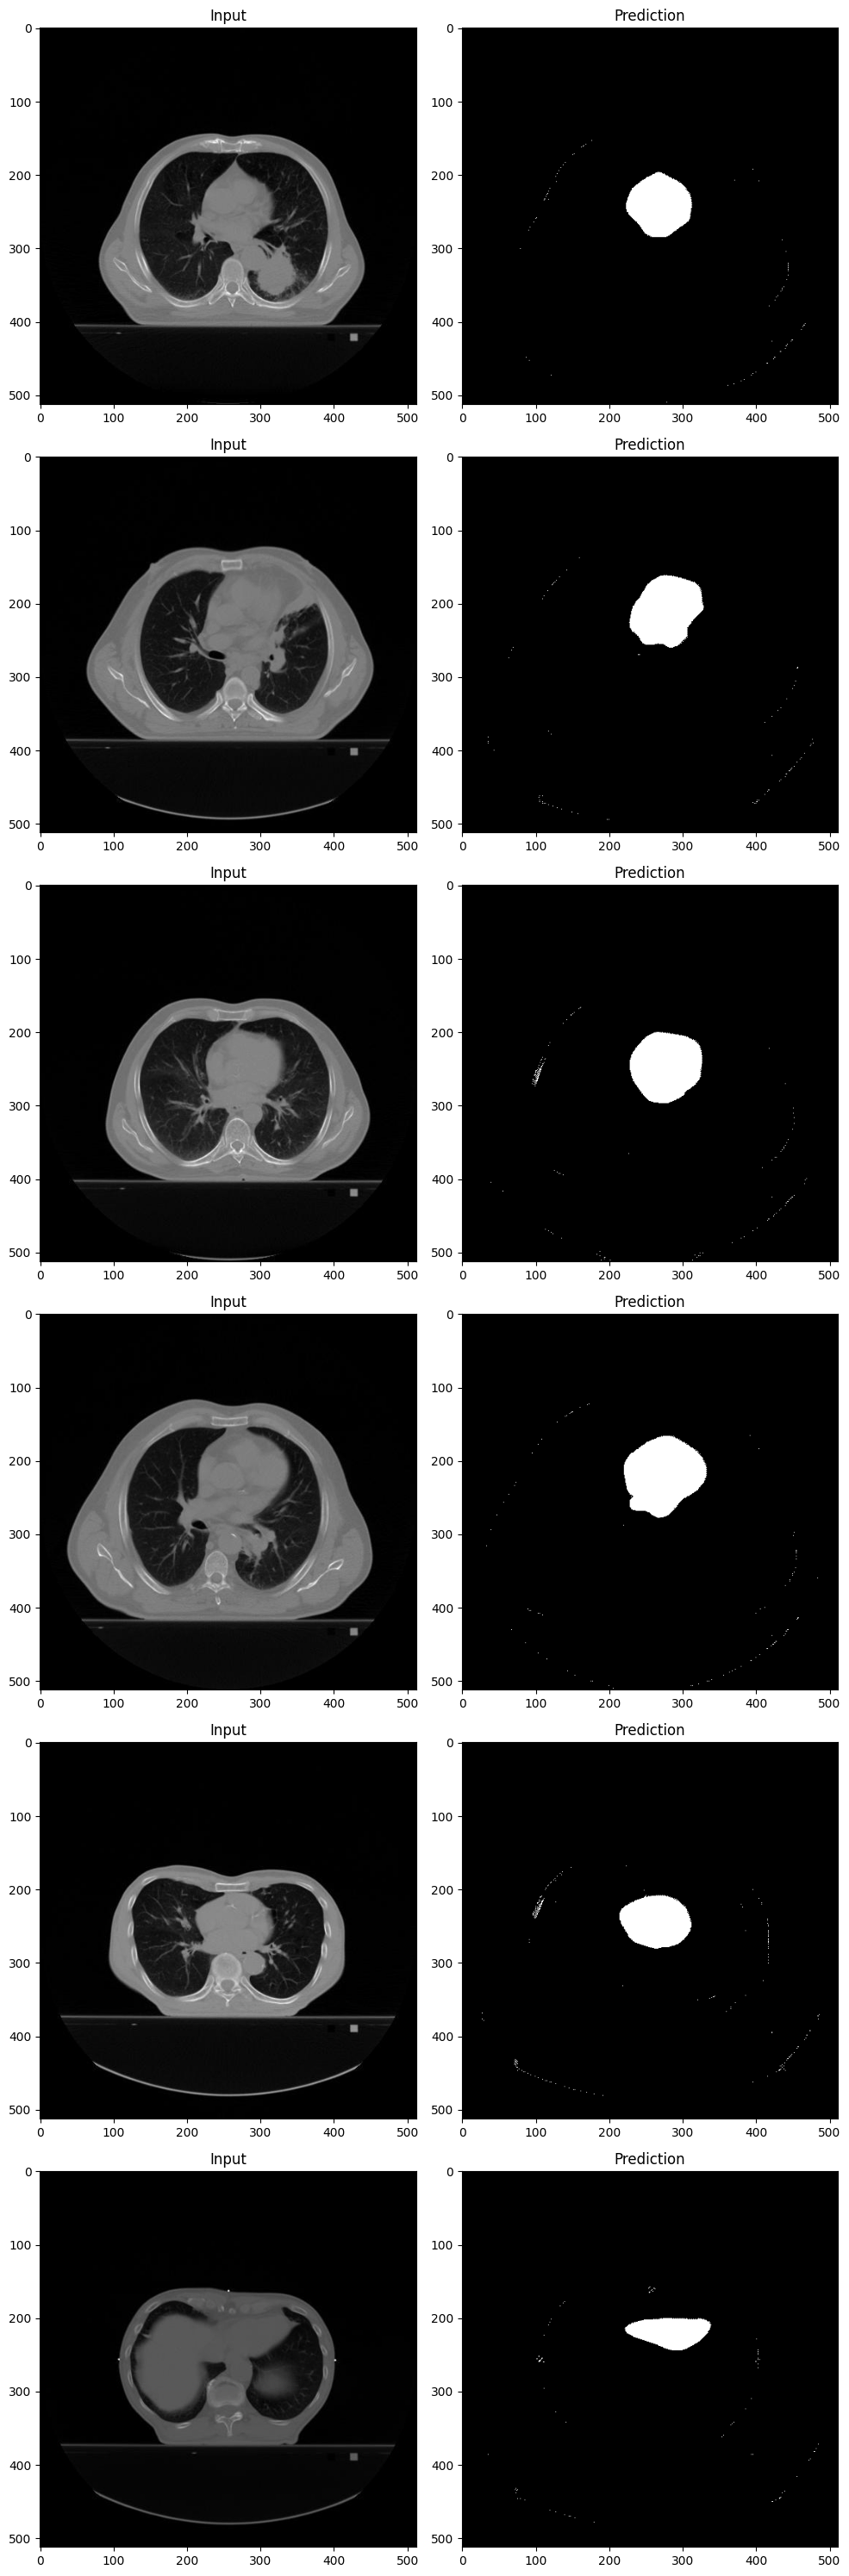

In [ ]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Test the model
test_model(model, test_loader)

Test Precision: 0.7755, Recall: 0.7983, F1 Score: 0.7809


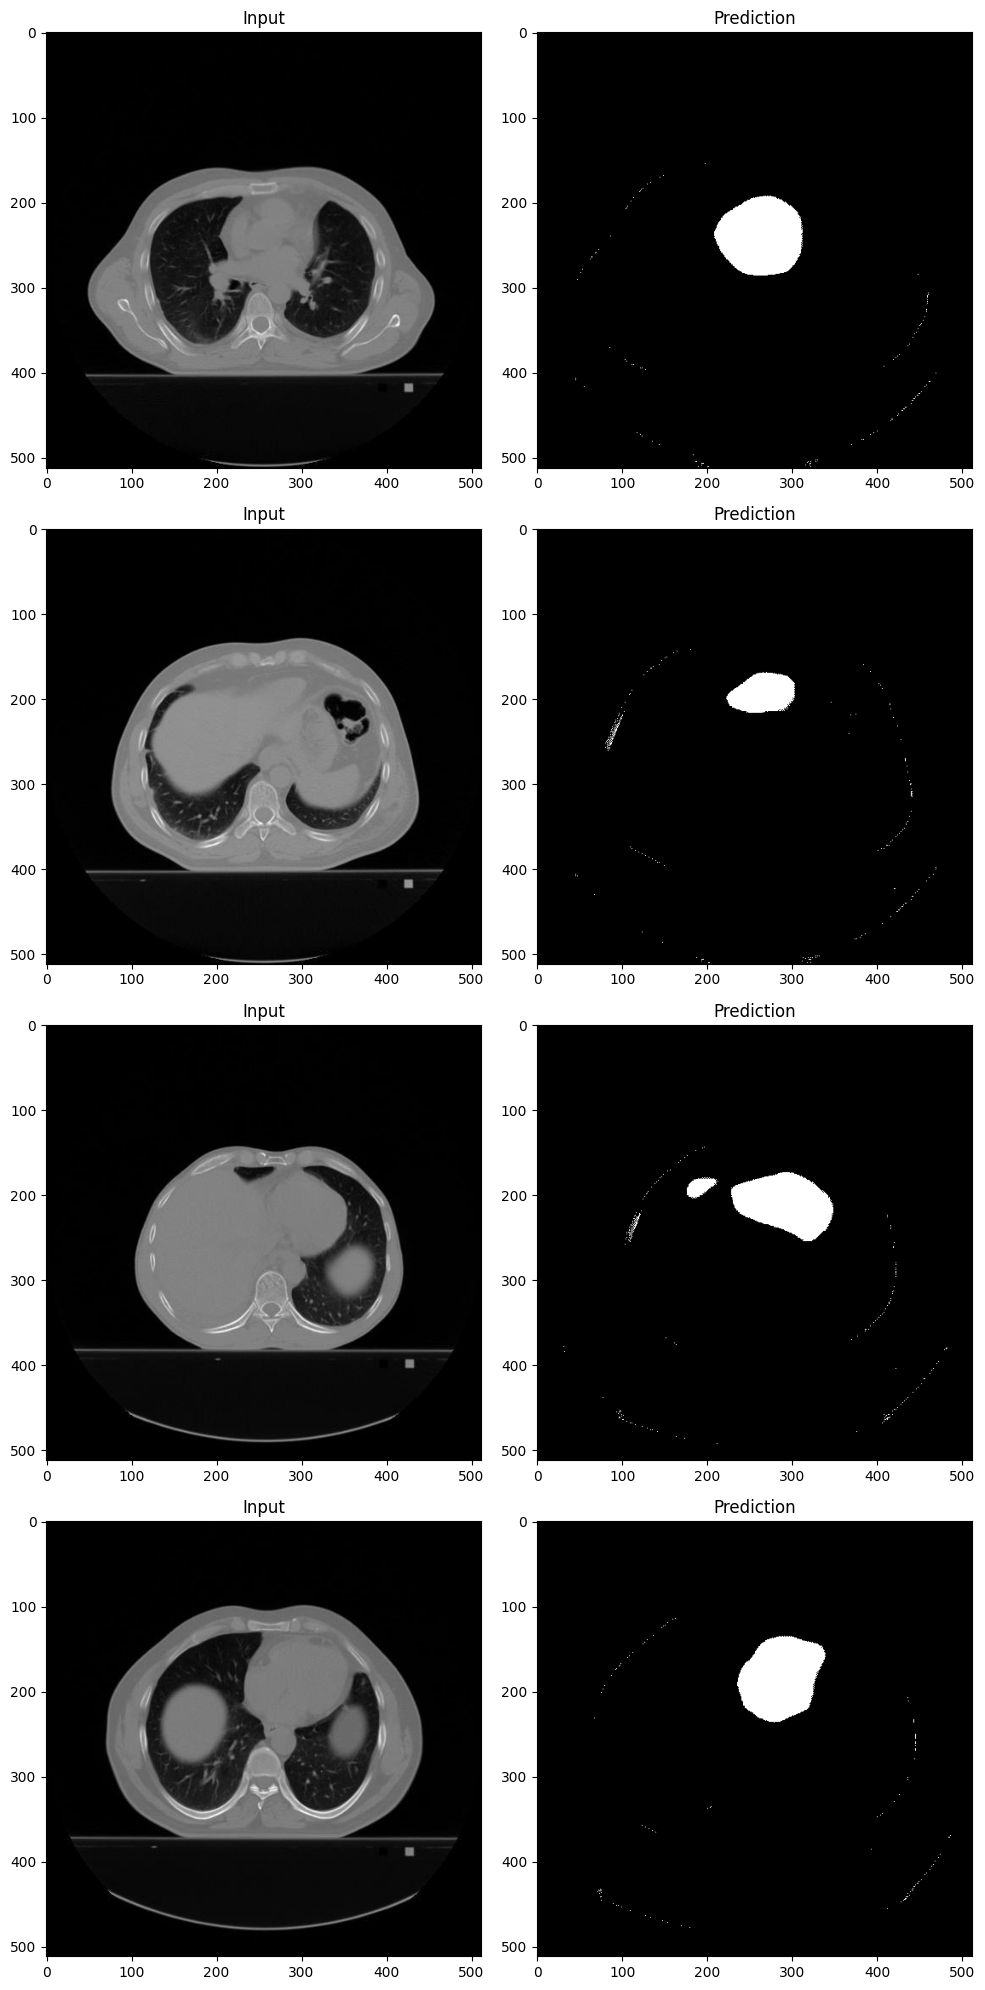

In [ ]:
test_model(model, val_loader)

# Part 2: Network Architecture Modification

In [40]:
class UNetModified(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, init_features=16):
        super(UNetModified, self).__init__()
        features = init_features

        self.encoder1 = UNetModified._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNetModified._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNetModified._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNetModified._block(features * 4, features * 8, name="bottleneck")

        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = UNetModified._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = UNetModified._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = UNetModified._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(in_channels=features, out_channels=out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))

        bottleneck = self.bottleneck(self.pool3(enc3))

        dec3 = self.upconv3(bottleneck)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=features,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
        )


In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score

Training U-Net with initial feature channels: 8
Epoch 1/25, Loss: 0.7023
Validation Loss: 0.6945, Precision: 0.0279, Recall: 1.0000, F1 Score: 0.0543
Epoch 2/25, Loss: 0.6845
Validation Loss: 0.6910, Precision: 0.0690, Recall: 0.6812, F1 Score: 0.1251
Epoch 3/25, Loss: 0.6683
Validation Loss: 0.6719, Precision: 0.1249, Recall: 0.8273, F1 Score: 0.2168
Epoch 4/25, Loss: 0.6548
Validation Loss: 0.6502, Precision: 0.1242, Recall: 0.9756, F1 Score: 0.2201
Epoch 5/25, Loss: 0.6445
Validation Loss: 0.6274, Precision: 0.1245, Recall: 0.9847, F1 Score: 0.2208
Epoch 6/25, Loss: 0.6358
Validation Loss: 0.6161, Precision: 0.1259, Recall: 0.9756, F1 Score: 0.2228
Epoch 7/25, Loss: 0.6280
Validation Loss: 0.6123, Precision: 0.1249, Recall: 0.9791, F1 Score: 0.2212
Epoch 8/25, Loss: 0.6207
Validation Loss: 0.6104, Precision: 0.1286, Recall: 0.9895, F1 Score: 0.2273
Epoch 9/25, Loss: 0.6137
Validation Loss: 0.6120, Precision: 0.1318, Recall: 0.9939, F1 Score: 0.2324
Epoch 10/25, Loss: 0.6064
Validati

Training U-Net with initial feature channels: 16
Epoch 1/25, Loss: 0.6142
Validation Loss: 0.6305, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch 2/25, Loss: 0.5857
Validation Loss: 0.6291, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch 3/25, Loss: 0.5677
Validation Loss: 0.6282, Precision: 0.0363, Recall: 0.0101, F1 Score: 0.0156
Epoch 4/25, Loss: 0.5542
Validation Loss: 0.6332, Precision: 0.1345, Recall: 0.7575, F1 Score: 0.2281
Epoch 5/25, Loss: 0.5429
Validation Loss: 0.6267, Precision: 0.1308, Recall: 0.9921, F1 Score: 0.2307
Epoch 6/25, Loss: 0.5329
Validation Loss: 0.6068, Precision: 0.1321, Recall: 0.9700, F1 Score: 0.2320
Epoch 7/25, Loss: 0.5238
Validation Loss: 0.5740, Precision: 0.1634, Recall: 0.9874, F1 Score: 0.2794
Epoch 8/25, Loss: 0.5156
Validation Loss: 0.5468, Precision: 0.2008, Recall: 0.9853, F1 Score: 0.3315
Epoch 9/25, Loss: 0.5079
Validation Loss: 0.5127, Precision: 0.1319, Recall: 0.3065, F1 Score: 0.1823
Epoch 10/25, Loss: 0.5021
Validat

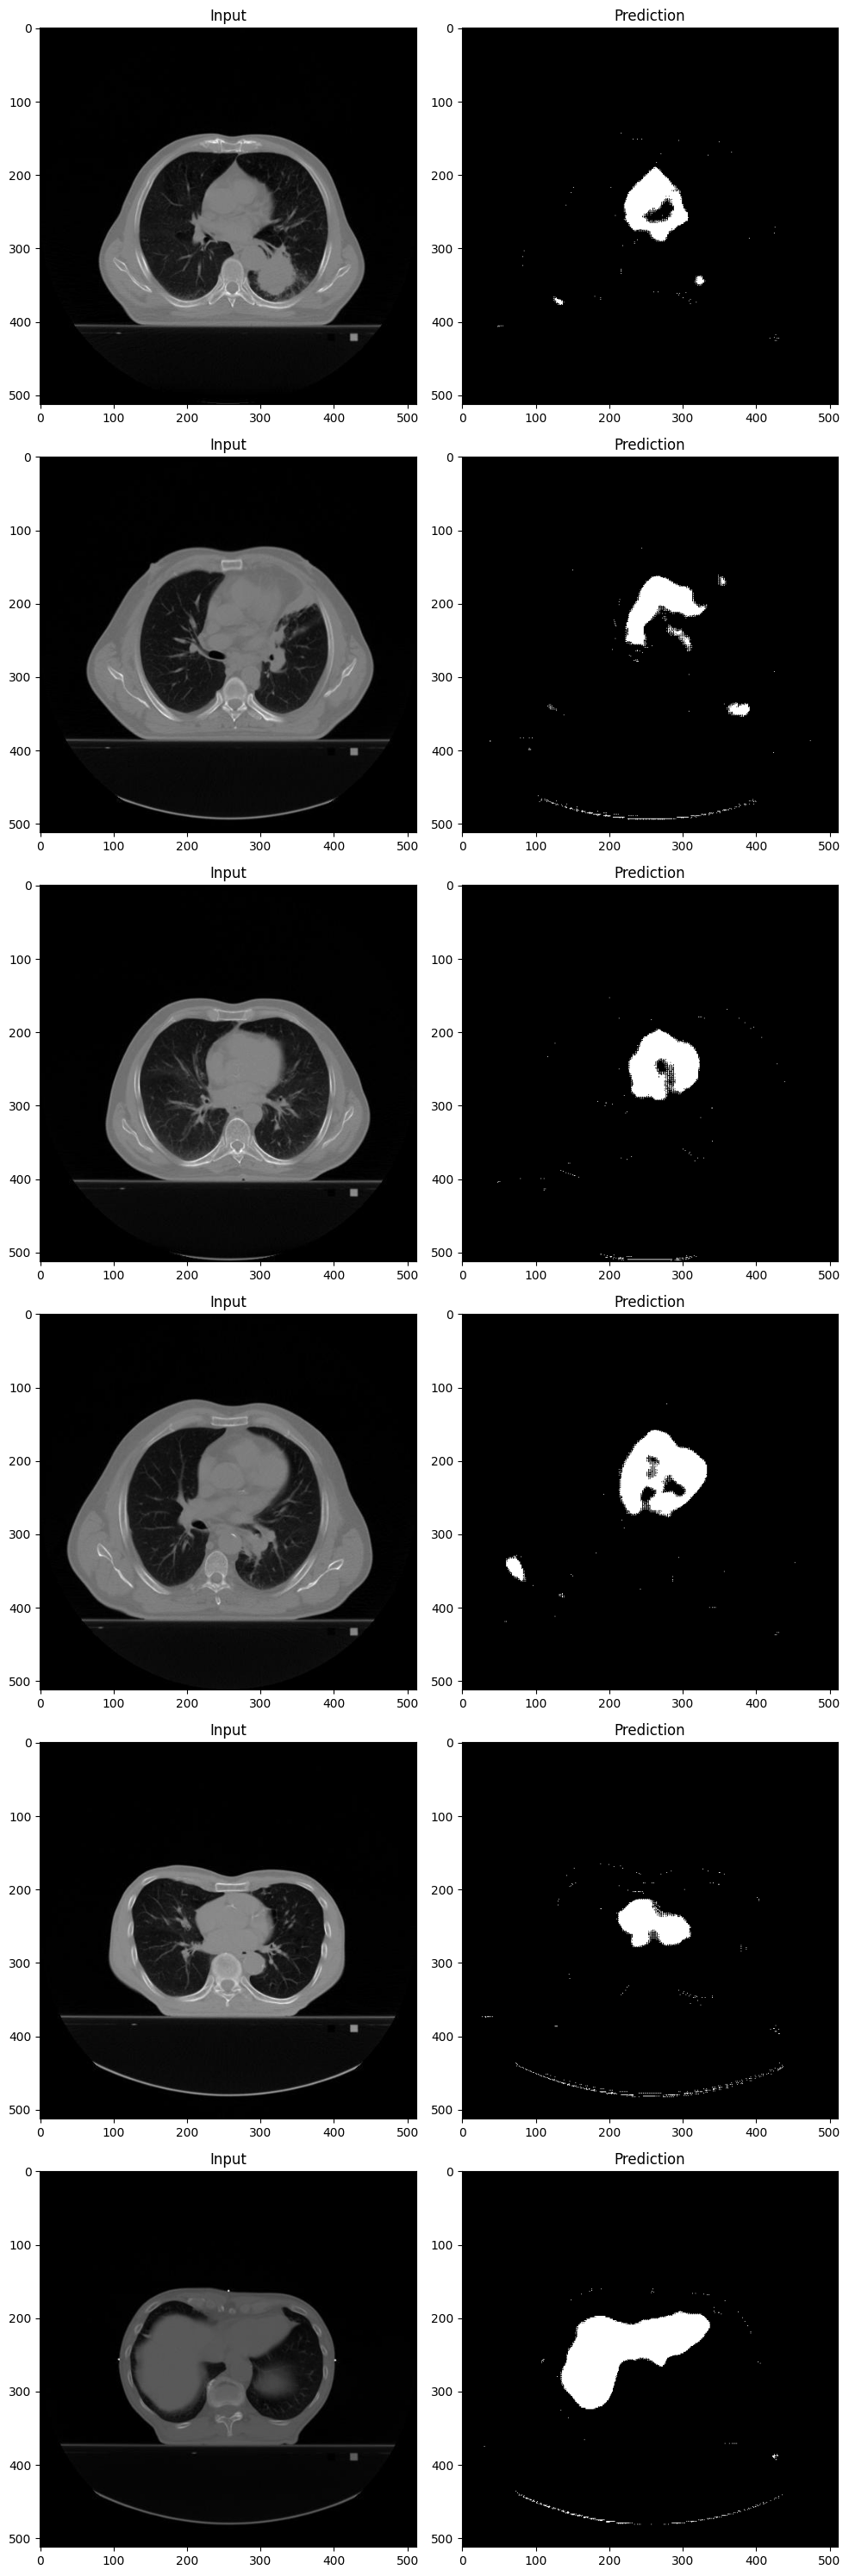

Training U-Net with initial feature channels: 32
Epoch 1/25, Loss: 0.6736
Validation Loss: 0.7405, Precision: 0.0278, Recall: 1.0000, F1 Score: 0.0540
Epoch 2/25, Loss: 0.6112
Validation Loss: 0.7308, Precision: 0.0278, Recall: 1.0000, F1 Score: 0.0540
Epoch 3/25, Loss: 0.5765
Validation Loss: 0.6722, Precision: 0.1098, Recall: 0.9999, F1 Score: 0.1975
Epoch 4/25, Loss: 0.5485
Validation Loss: 0.6095, Precision: 0.1213, Recall: 0.9797, F1 Score: 0.2155
Epoch 5/25, Loss: 0.5252
Validation Loss: 0.5241, Precision: 0.1181, Recall: 0.1708, F1 Score: 0.1299
Epoch 6/25, Loss: 0.5049
Validation Loss: 0.4950, Precision: 0.0718, Recall: 0.0443, F1 Score: 0.0546
Epoch 7/25, Loss: 0.4879
Validation Loss: 0.5141, Precision: 0.0528, Recall: 0.0255, F1 Score: 0.0344
Epoch 8/25, Loss: 0.4719
Validation Loss: 0.4976, Precision: 0.1246, Recall: 0.0485, F1 Score: 0.0687
Epoch 9/25, Loss: 0.4577
Validation Loss: 0.4786, Precision: 0.4783, Recall: 0.3045, F1 Score: 0.3598
Epoch 10/25, Loss: 0.4455
Validat

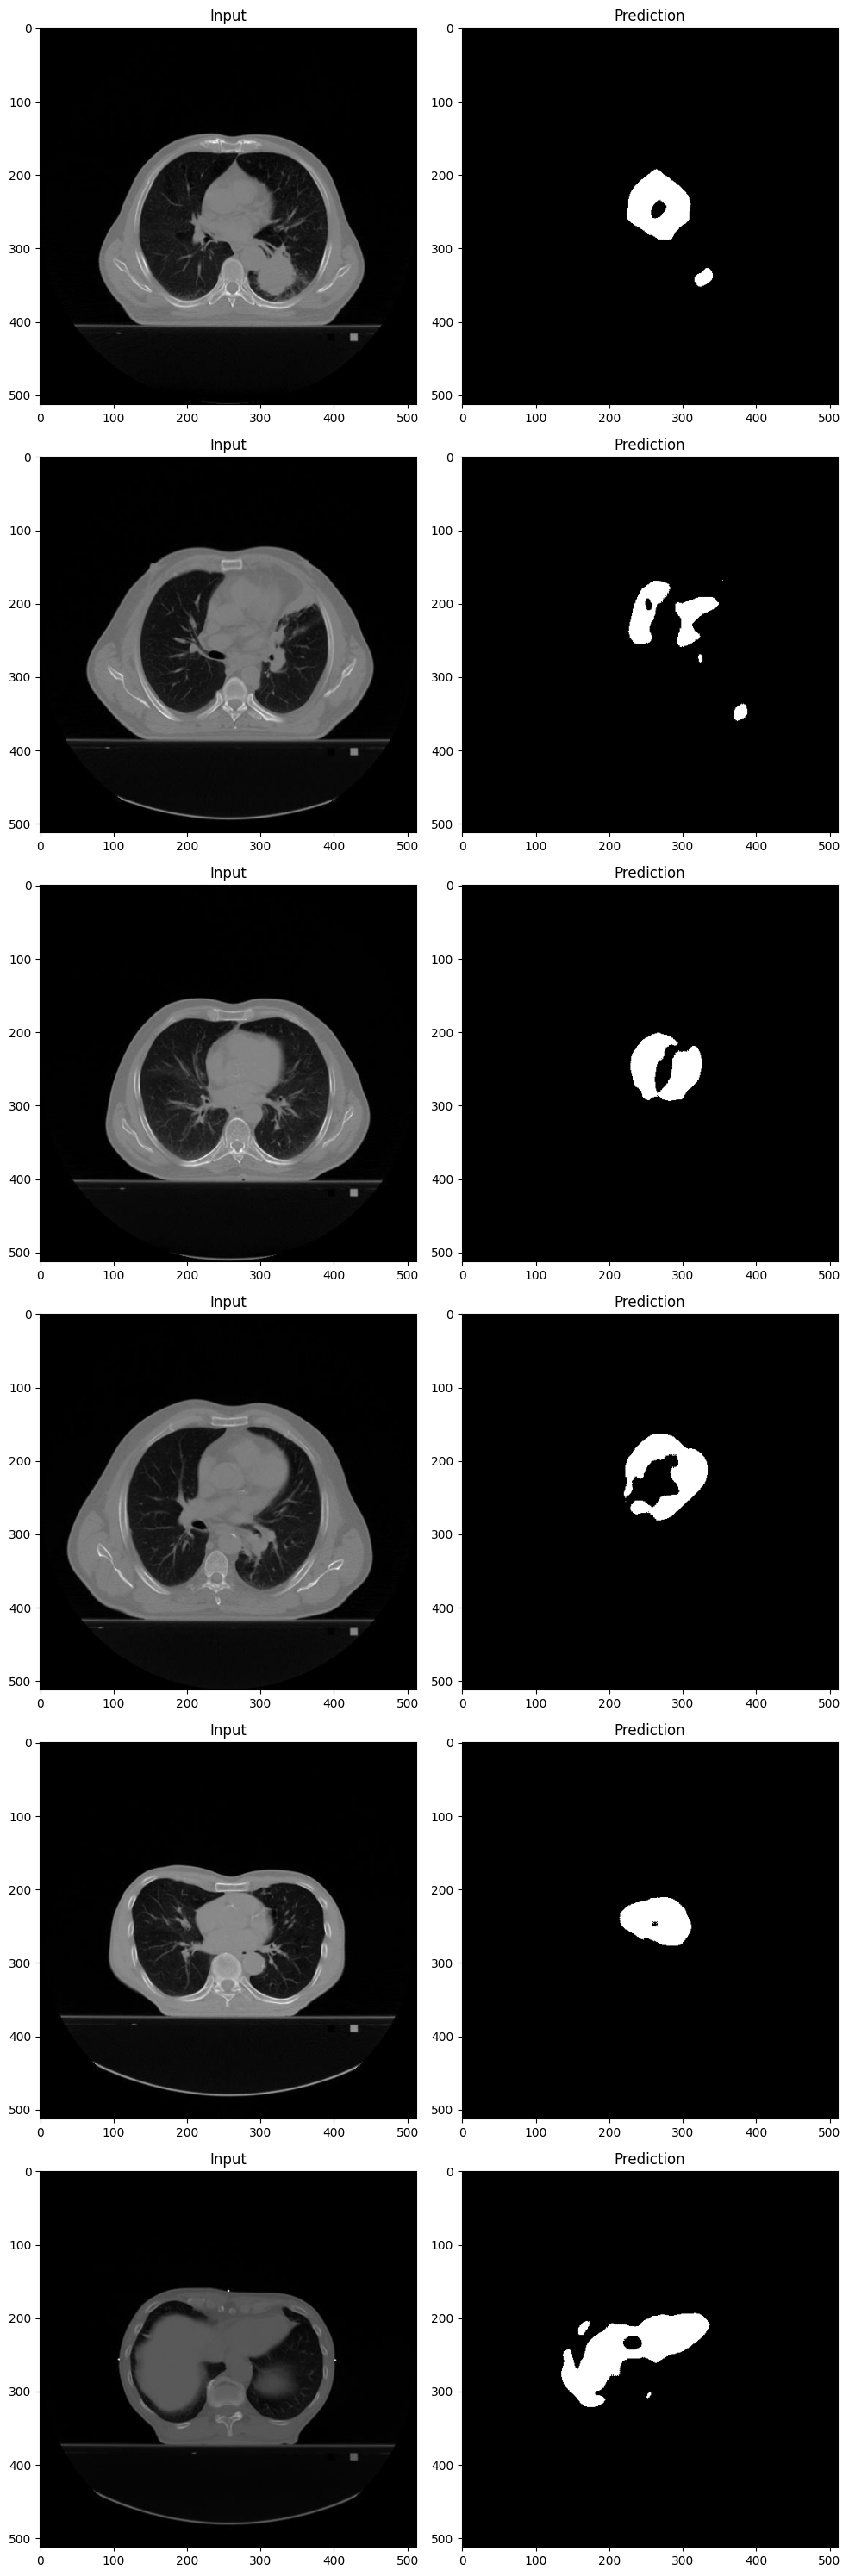

In [43]:
# Instantiate and train the modified models
init_features_list = [8, 16, 32]

for init_features in init_features_list:
    print(f"Training U-Net with initial feature channels: {init_features}")
    model = UNetModified(in_channels=1, out_channels=1, init_features=init_features).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = BCELoss()

    train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25)
    model.load_state_dict(torch.load('best_model.pth'))
    test_model(model, test_loader)

#Part 3: Dropout in Network Architecture

In [46]:
import torch.nn.functional as F

class UNetWithDropout(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, init_features=16, dropout_p=0.5):
        super(UNetWithDropout, self).__init__()
        features = init_features

        self.encoder1 = UNetWithDropout._block(in_channels, features, dropout_p, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNetWithDropout._block(features, features * 2, dropout_p, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNetWithDropout._block(features * 2, features * 4, dropout_p, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNetWithDropout._block(features * 4, features * 8, dropout_p, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNetWithDropout._block(features * 8, features * 16, dropout_p, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = UNetWithDropout._block((features * 8) * 2, features * 8, dropout_p, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = UNetWithDropout._block((features * 4) * 2, features * 4, dropout_p, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = UNetWithDropout._block((features * 2) * 2, features * 2, dropout_p, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = UNetWithDropout._block(features * 2, features, dropout_p, name="dec1")

        self.conv = nn.Conv2d(in_channels=features, out_channels=out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, dropout_p, name):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_p),
            nn.Conv2d(
                in_channels=features,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_p),
        )


Training U-Net with dropout probability: 0.2
Epoch 1/25, Loss: 0.6837
Validation Loss: 0.6598, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch 2/25, Loss: 0.6706
Validation Loss: 0.6435, Precision: 0.0201, Recall: 0.0156, F1 Score: 0.0176
Epoch 3/25, Loss: 0.6583
Validation Loss: 0.6355, Precision: 0.1439, Recall: 0.9247, F1 Score: 0.2485
Epoch 4/25, Loss: 0.6462
Validation Loss: 0.6232, Precision: 0.1253, Recall: 0.9935, F1 Score: 0.2223
Epoch 5/25, Loss: 0.6336
Validation Loss: 0.6119, Precision: 0.1208, Recall: 1.0000, F1 Score: 0.2152
Epoch 6/25, Loss: 0.6209
Validation Loss: 0.6107, Precision: 0.1193, Recall: 1.0000, F1 Score: 0.2129
Epoch 7/25, Loss: 0.6085
Validation Loss: 0.6208, Precision: 0.1190, Recall: 1.0000, F1 Score: 0.2125
Epoch 8/25, Loss: 0.5952
Validation Loss: 0.6542, Precision: 0.1186, Recall: 1.0000, F1 Score: 0.2118
Epoch 9/25, Loss: 0.5845
Validation Loss: 0.6579, Precision: 0.1199, Recall: 1.0000, F1 Score: 0.2138
Epoch 10/25, Loss: 0.5726
Validation 

Training U-Net with dropout probability: 0.5
Epoch 1/25, Loss: 0.6694
Validation Loss: 0.6662, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch 2/25, Loss: 0.6611
Validation Loss: 0.6468, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch 3/25, Loss: 0.6538
Validation Loss: 0.6330, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch 4/25, Loss: 0.6472
Validation Loss: 0.6142, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch 5/25, Loss: 0.6412
Validation Loss: 0.6022, Precision: 0.0061, Recall: 0.0026, F1 Score: 0.0037
Epoch 6/25, Loss: 0.6355
Validation Loss: 0.6007, Precision: 0.1488, Recall: 0.6921, F1 Score: 0.2384
Epoch 7/25, Loss: 0.6303
Validation Loss: 0.6039, Precision: 0.1314, Recall: 0.9508, F1 Score: 0.2307
Epoch 8/25, Loss: 0.6252
Validation Loss: 0.6119, Precision: 0.1256, Recall: 0.9851, F1 Score: 0.2226
Epoch 9/25, Loss: 0.6202
Validation Loss: 0.6242, Precision: 0.1233, Recall: 0.9999, F1 Score: 0.2192
Epoch 10/25, Loss: 0.6154
Validation 

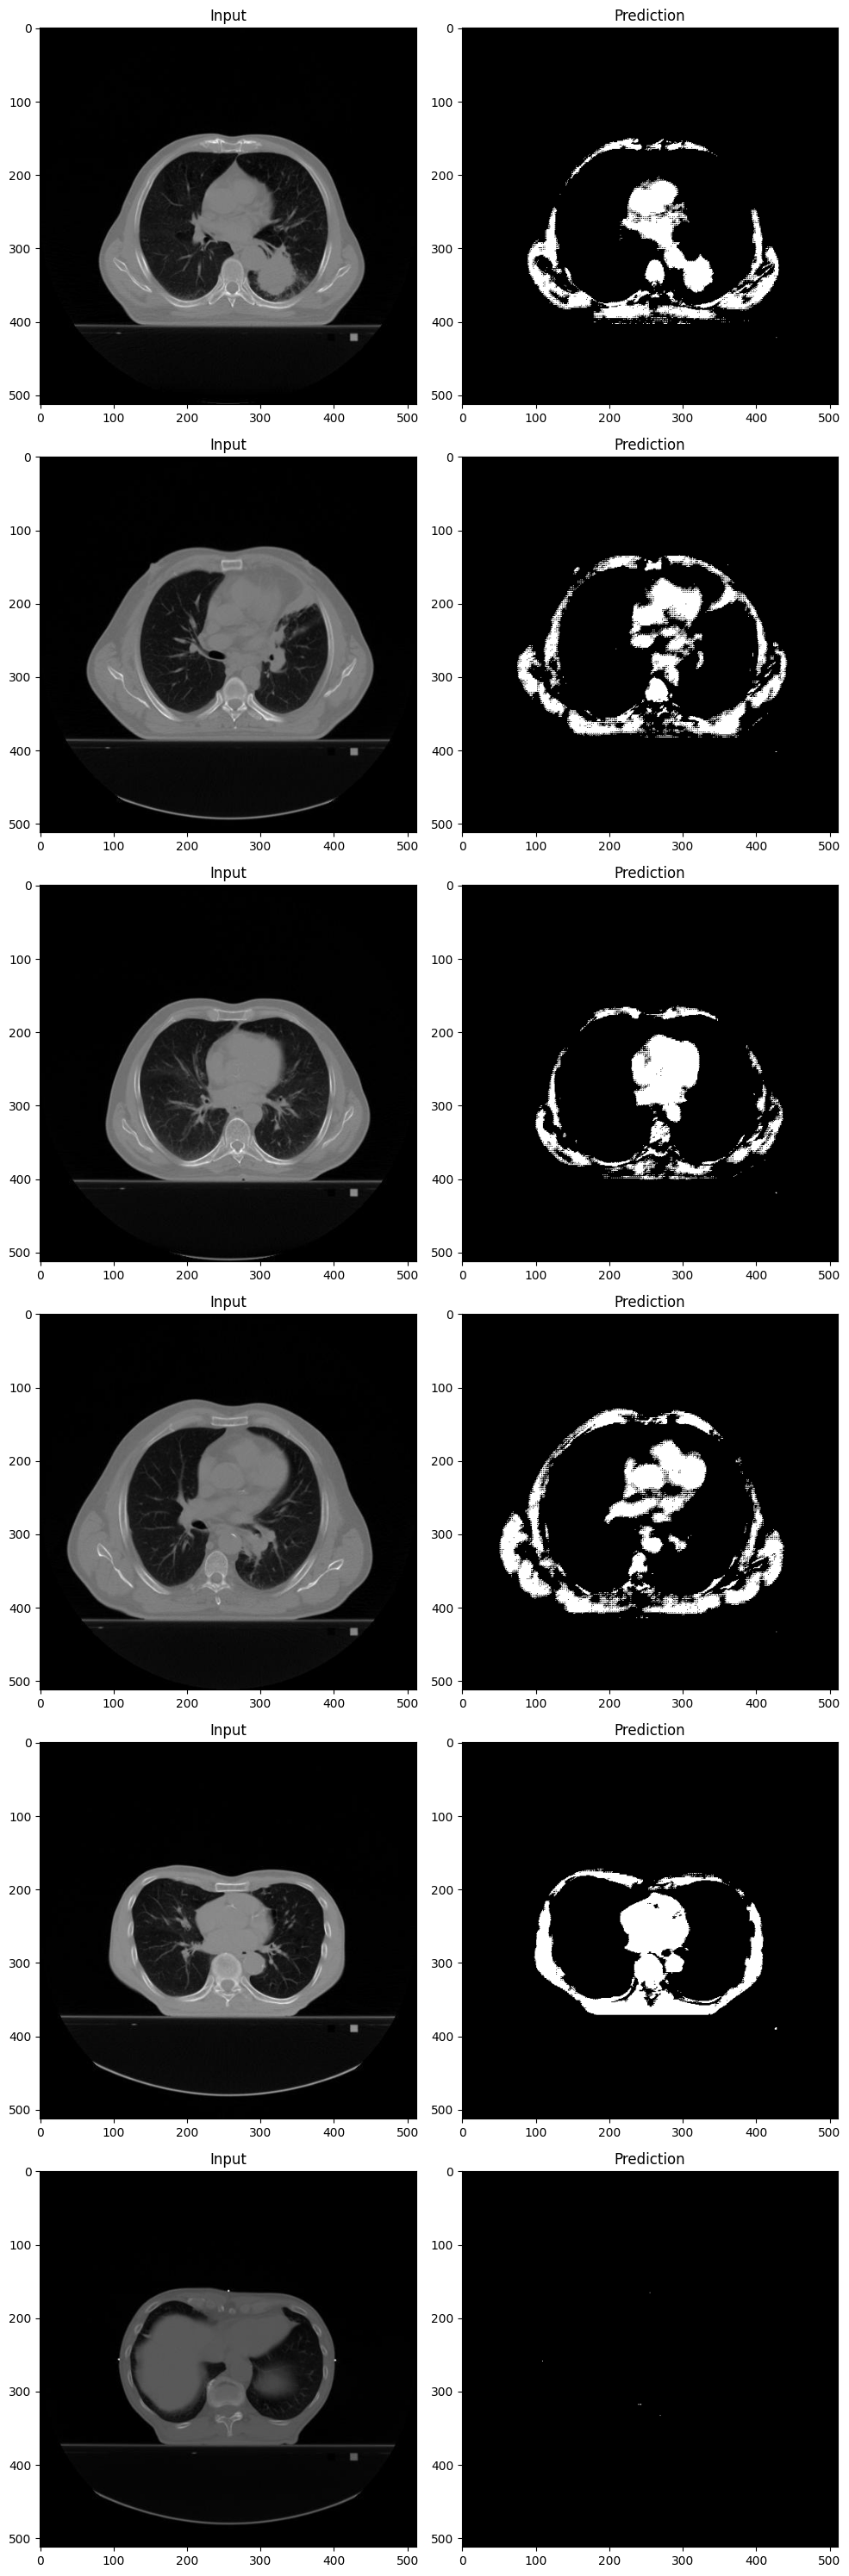

Training U-Net with dropout probability: 0.7
Epoch 1/25, Loss: 0.6169
Validation Loss: 0.6729, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch 2/25, Loss: 0.6061
Validation Loss: 0.6626, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch 3/25, Loss: 0.5977
Validation Loss: 0.6452, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch 4/25, Loss: 0.5910
Validation Loss: 0.6298, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch 5/25, Loss: 0.5856
Validation Loss: 0.6213, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch 6/25, Loss: 0.5808
Validation Loss: 0.6124, Precision: 0.0060, Recall: 0.0024, F1 Score: 0.0034
Epoch 7/25, Loss: 0.5765
Validation Loss: 0.6049, Precision: 0.0790, Recall: 0.1518, F1 Score: 0.1030
Epoch 8/25, Loss: 0.5725
Validation Loss: 0.5987, Precision: 0.1310, Recall: 0.4610, F1 Score: 0.1932
Epoch 9/25, Loss: 0.5688
Validation Loss: 0.5939, Precision: 0.1522, Recall: 0.7946, F1 Score: 0.2524
Epoch 10/25, Loss: 0.5652
Validation 

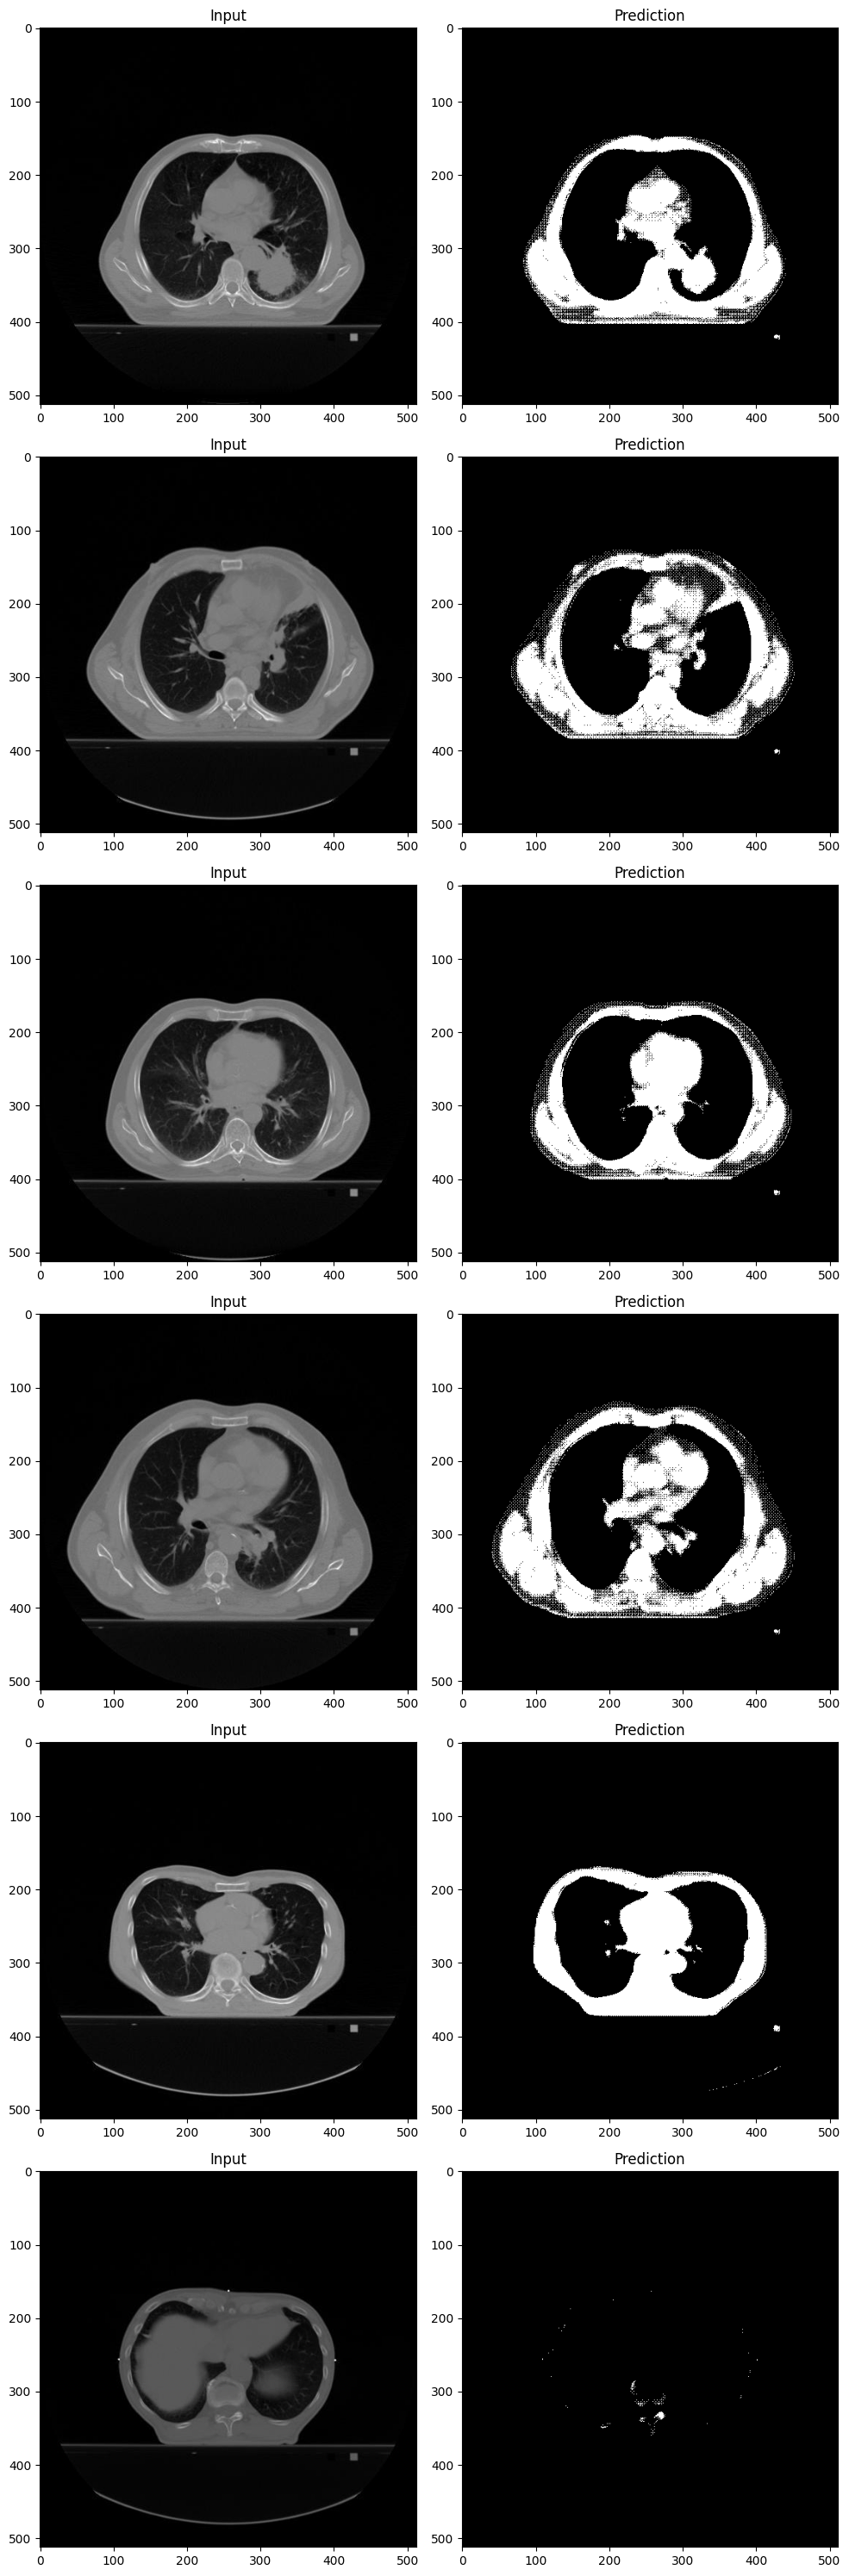

In [47]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate and train the modified models with dropout
dropout_p_values = [0.2, 0.5, 0.7]
results = []

for dropout_p in dropout_p_values:
    print(f"Training U-Net with dropout probability: {dropout_p}")
    model = UNetWithDropout(in_channels=1, out_channels=1, init_features=16, dropout_p=dropout_p).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = BCELoss()

    train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25)
    model.load_state_dict(torch.load('best_model.pth'))
    test_model(model, test_loader)

